# Problemas de clasificación.

## MNIST Dataset 

Cada vez que se crea un nuevo algoritmo de clasificación, se tiene curiosidad por ver cómo funcionará en MNIST 

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()
X, y = mnist["data"], mnist["target"]

In [2]:
X.shape , y.shape ,"type y: " ,type(y)  

((70000, 784), (70000,), 'type y: ', numpy.ndarray)

target : 5 <class 'str'>


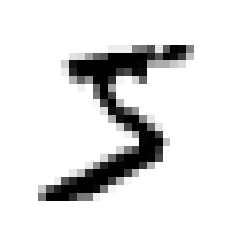

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 

some_digit = X[0]
print("target :", y[0], type(y[0]))
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
#change format: str to interger 
y = y.astype(np.uint8)

Siempre hay que crear un conjunto de pruebas y dejarlo a un lado **antes de inspeccionar los datos con detenimiento.**
Tambien se debe asegurar que los datos esten barajados, para que en el momento que se haga cross-validation a algun fold no le falte algun ejemplo de algun numero. Alguno de los algoritmos de ML son menos eficientes si se le pasan intancias de la misma clase de forma seguida.

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier. 

En primera instancia solo se buscara hacer un clasificador que reconozca un solo numero. Partiremos con el 5, por lo tanto el problema se traduciria a un clasificador binario, es 5 o no es 5.  

In [6]:
#True cuando es 5
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Un buen clasificador para empezar a hacer prueba es el SGD(Stochastic Gradient Descent). Tiene la ventaja de trabajar bien con grandes conjuntos de datos de manera eficiente (por la cualidad anterior SGD es buena opción para el aprendizaje online).  

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1# // parte entera de la división 
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

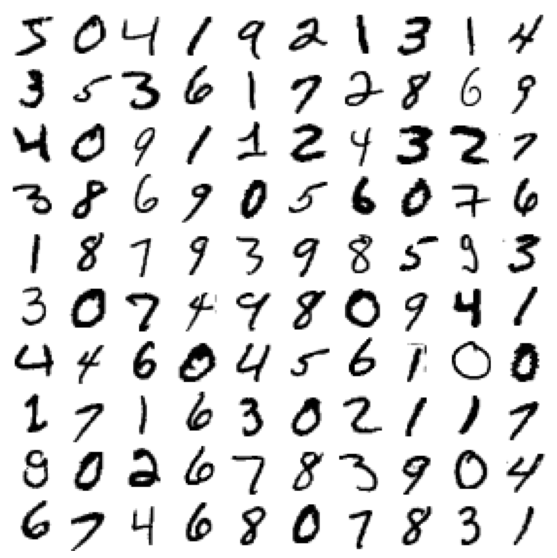

In [9]:
plt.figure(figsize=(10,10))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

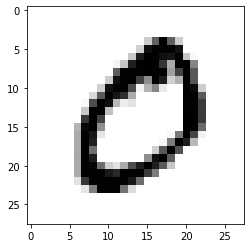

In [11]:
example = X[1]
example_img = example.reshape(28, 28)
plt.imshow(example_img, cmap="binary")

In [12]:
print(sgd_clf.predict([some_digit]))
print(sgd_clf.predict([example]))

[ True]
[False]


Vemos que el clasificador funciona, pero necesitamos obtener una metrica de su presición. 

## Medidas de rendimiento

Evaluar un clasificador suele ser mucho más complicado que evaluar un regresor, por lo que dedicaremos gran parte de este capítulo a este tema.

### Medición de la precisión mediante la validación cruzada

Una buena forma de evaluar un modelo es utilizar la validación cruzada, tal y como se hizo en el capítulo 2.

**IMPLEMENTACIÓN DE LA VALIDACIÓN CRUZADA**

En ocasiones, necesitará un mayor control sobre el proceso de validación cruzada que el que proporciona Scikit-Learn. Por lo que debemos implementarla por nosotros mismos. 

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#Note: shuffle=True was omitted by mistake in previous releases of the book. 

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


La clase StratifiedKFold realiza un muestreo estratificado (como se explica en el capítulo 2) para producir pliegues que contengan una proporción representativa de cada clase. En cada iteración, el código crea un clon del clasificador, entrena ese clon en los folds de entrenamiento y hace predicciones en el fold de prueba. A continuación, cuenta el número de predicciones correctas y emite la proporción de predicciones correctas.

Utilicemos la función cross_val_score() para evaluar nuestro modelo SGDClassifier, utilizando la validación cruzada K-fold con tres pliegues.

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

¡Vaya! ¿Más del 93% de precisión? Bueno, antes de que te emociones demasiado, veamos un clasificador muy tonto que simplemente clasifica todas las imágenes en la clase "no 5":


In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Así es, ¡tiene más del 90% de precisión! Esto se debe simplemente a que sólo un 10% de las imágenes son 5s, así que si siempre adivinas que una imagen no es un 5, acertarás un 90% de las veces. Supera a Nostradamus.

**Esto demuestra por qué la precisión no suele ser la medida de rendimiento preferida para los clasificadores, especialmente cuando se trata de conjuntos de datos sesgados (es decir, cuando algunas clases son mucho más frecuentes que otras).**

### Confusion Matrix

Una forma mucho mejor de evaluar el rendimiento de un clasificador es mirar la matriz de confusión. La idea general es contar el número de veces que las instancias de la clase A se clasifican como clase B. Por ejemplo, para saber el número de veces que el clasificador confundió imágenes de 5s con 3s, se miraría en la quinta fila y la tercera columna de la matriz de confusión.

Para calcular la matriz de confusión, primero hay que tener un conjunto de predicciones para poder compararlas con los objetivos reales. Podría hacer predicciones en el conjunto de prueba, pero vamos a mantenerlo intacto por ahora (recuerde que quiere usar el conjunto de prueba sólo al final de su proyecto, una vez que tenga un clasificador que esté listo para lanzar). En su lugar, puedes utilizar la función cross_val_predict():

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Al igual que la función cross_val_score(), cross_val_predict() realiza una validación cruzada de K fold, pero en lugar de devolver las puntuaciones de evaluación, devuelve las predicciones realizadas en cada fold de prueba. 


<AxesSubplot:>

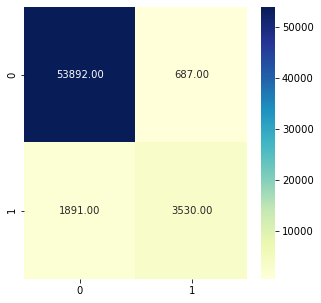

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

con_matrix = confusion_matrix(y_train_5, y_train_pred)

fig, ax = plt.subplots(1, figsize=(5,5))  # 1 sólo gráfico, en un cuadrado
sns.heatmap(con_matrix, annot=True, fmt='.2f', cmap="YlGnBu")

La primera fila de esta matriz considera las imágenes de no-5 (la clase negativa): 53.057 de ellas se clasificaron correctamente como no-5 (se denominan verdaderos negativos), mientras que las 1.522 restantes se clasificaron erróneamente como 5s (falsos positivos). La segunda fila considera las imágenes de 5s (la clase positiva): 1.325 fueron clasificadas erróneamente como no-5s (falsos negativos), mientras que las 4.096 restantes fueron clasificadas correctamente como 5s (verdaderos positivos). 

La matriz de confusión le ofrece mucha información, pero a veces puede preferir una métrica más concisa. Una métrica interesante es la exactitud de las predicciones positivas, que se denomina precisión del clasificador. 
$$
\text{precision}= \frac{TP}{TP + FP}
$$
TP es el número de verdaderos positivos, y FP es el número de falsos positivos. 

La precisión se suele utilizar junto con otra métrica denominada recall, también llamada sensibilidad o tasa de verdaderos positivos (TPR): es la proporción de casos positivos que el clasificador detecta correctamente.
$$
\text{recall}= \frac{TP}{TP + FN}
$$
FN son los falsos negativos.

### Precisión y recall(sensibilidad).

Scikit-Learn proporciona varias funciones para calcular las métricas del clasificador, incluyendo la precisión y el recall:

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1522)

print(recall_score(y_train_5, y_train_pred)) # == 4096 / (4096 + 1325)


0.8370879772350012
0.6511713705958311


Con estas metricas uno puede ver de forma más precisa cual es el rendimiento de nuestro algoritmo. 

A menudo es conveniente combinar la precisión y el recall en una sola métrica en una sola métrica llamada $F_1$ score, en particular si se necesita una forma sencilla de comparar dos clasificadores. $F_1$ score es la *harmonic mean* de la precisión y el recall. Mientras que la media normal trata todos los valores por igual, la *harmonic mean* da mucho más peso a los valores bajos. Como resultado, el clasificador sólo obtendrá una puntuación F alta si tanto el recall como la precisión son altos.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} =2 \times \frac{\text{precision} \times \text{recall} }{\text{precision} +\text{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}
$$

In [20]:
#To compute the F score call the f1_score() function

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

La F score favorece a los clasificadores que tienen una precisión y un recall similares. Esto no es lo que simpre se desea:en algunos contextos se preocupa sobre todo por la precisión, y en otros contextos se preocupa realmente por el recall. Ejemplo de pacientes con cancer hay que decidir cual de las dos puntuaciones se debera tener más acierto. 

Solo hay un gran problema, no se pueden tener las dos cosas: el aumento de la precisión reduce el recall, y viceversa. Es lo que se denomina el *precision/recall trade-off*.


### Compensación Precision/recall.  

Para entender este equilibrio, veamos cómo el SGDClassifier toma sus decisiones de clasificación. Para cada instancia, calcula una puntuación basada en una *decision function*. Si esa puntuación es mayor que un umbral, asigna la instancia a la clase positiva; en caso contrario, la asigna a la clase negativa. La figura muestra unos dígitos situados desde la puntuación más baja a la izquierda hasta la más alta a la derecha. Supongamos que el umbral de decisión se sitúa en la flecha central (entre los dos 5): encontrará 4 verdaderos positivos (5 reales) a la derecha de ese umbral, y 1 falso positivo (en realidad un 6). Por tanto, con ese umbral, la precisión es del 80% (4 de 5). Pero de los 6 5 reales, el clasificador sólo detecta 4, por lo que el recall es del 67% (4 de 6). Si se eleva el umbral (moviéndolo hacia la flecha de la derecha), el falso positivo (el 6) se convierte en un verdadero negativo, con lo que aumenta la precisión (hasta el 100% en este caso), pero un verdadero positivo se convierte en un falso negativo, con lo que el recall disminuye hasta el 50%. A la inversa, la reducción del umbral aumenta el recall y reduce la precisión.

<img src="img/diagrama20_c3.png" height="900px" width="600px" />

Scikit-Learn no permite establecer el umbral directamente, pero sí da acceso a las puntuaciones de decisión que utiliza para hacer predicciones. En lugar de llamar al método predict() del clasificador, puede llamar a su método decision_function(), que devuelve una puntuación para cada instancia, y luego utilizar cualquier umbral que desee para hacer predicciones basadas en esas puntuaciones:


In [21]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[2164.22030239]


In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
#SGDClassifier utiliza un umbral cerca de 0
# si aumentemos el umbral
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]
[False]


Esto confirma que el aumento del umbral disminuye el recall. La imagen representa realmente un 5, y el clasificador lo detecta cuando el umbral es 0, pero no lo detecta cuando se aumenta el umbral a 8.000.

¿Cómo se decide qué umbral utilizar? En primer lugar, utilice la función cross_val_predict() para obtener las puntuaciones de todas las instancias del conjunto de entrenamiento, pero esta vez especifique que desea devolver las puntuaciones de decisión en lugar de las predicciones:


In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Con estas puntuaciones, utilice la función precision_recall_curve() para calcular la precisión y el recall para todos los umbrales posibles:

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)


In [25]:
print(len(precisions), len(recalls), len(thresholds))
print(len(precisions[:-1]))


59967 59967 59966
59966


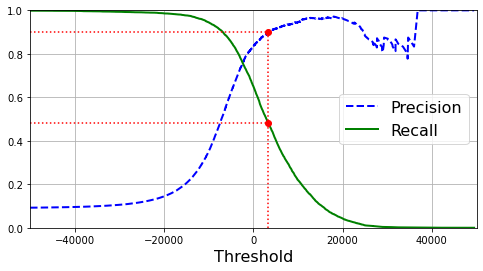

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
                                     
plt.show()

**NOTA**|
:----------------------------:|
Tal vez se pregunte por qué la curva de precisión es más irregular que la de recall en la Figura 3-4. La razón es que la precisión puede bajar a veces cuando se aumenta el umbral (aunque en general subirá). Para entender el motivo, vuelva a mirar la figura 3-3 y observe lo que ocurre cuando parte del umbral central y lo desplaza un solo dígito hacia la derecha: la precisión pasa de 4/5 (80%) a 3/4 (75%). Por otro lado, el recall sólo puede bajar cuando se aumenta el umbral, lo que explica que su curva parezca suave.

Otra forma de seleccionar un buen equilibrio entre precisión y recall es graficar la precisión directamente contra el recall, como se muestra en la siguiente grafica (se ha resaltado el mismo umbral que antes).

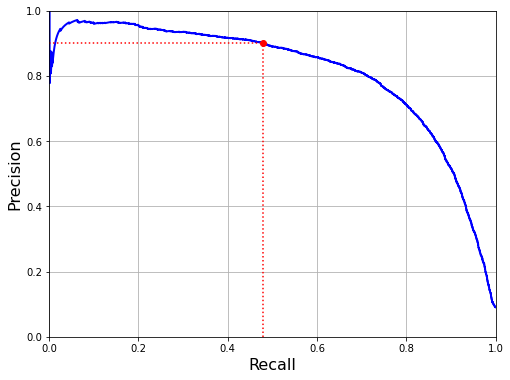

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

Se puede ver que la precisión empieza a caer bruscamente en torno al 80% del recall. Probablemente querrá seleccionar un equilibrio entre precisión y recall justo antes de esa caída, por ejemplo, en torno al 60% de recuperación. Pero, por supuesto, la elección depende de su proyecto.

Supongamos que decide buscar una precisión del 90%. Buscas el primer gráfico y descubres que necesitas utilizar un umbral de unos 8.000. Para ser más preciso, puede buscar el umbral más bajo que le dé al menos un 90% de precisión (np.argmax() le dará el primer índice del valor máximo, que en este caso significa el primer valor Verdadero):

In [28]:
print(np.argmax(precisions >= 0.90))#retorna el indice del primero valor que cumple la condicion 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
threshold_90_precision

57075


3370.0194991439557

Para hacer predicciones (en el conjunto de entrenamiento por ahora), en lugar de llamar al método predict() del clasificador, puedes ejecutar este código:

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))


0.9000345901072293
0.4799852425751706


Genial, ¡tienes un clasificador con un 90% de precisión! Como puedes ver, es bastante fácil crear un clasificador con prácticamente cualquier precisión que quieras: sólo tienes que establecer un umbral lo suficientemente alto, y ya está. Pero espere, no tan rápido. Un clasificador de alta precisión no es muy útil si su recall es demasiado baja.

CONSEJO
Si alguien dice: "Alcancemos el 99% de precisión", debe preguntar: "¿A qué recall?".

### La curva ROC

La curva ROC (característica operativa del receptor) es otra herramienta común utilizada con los **clasificadores binarios**. Es muy similar a la curva de precisión/recall, pero en lugar de graficar la precisión frente al recall, la curva ROC grafica la *tasa de verdaderos positivos* (otro nombre para el recall) frente a la *tasa de falsos positivos* (FPR). El FPR es la proporción de casos negativos que se clasifican incorrectamente como positivos. Es igual a $1 - \text{la tasa de verdaderos negativos}$ (TNR), que es la proporción de casos negativos que se clasifican correctamente como negativos. El TNR también se denomina especificidad. Por lo tanto, la curva ROC traza la sensibilidad (recuerdo) frente a $1 - \text{la especificidad}$.

Para trazar la curva ROC, primero se utiliza la función roc_curve() para calcular el TPR y el FPR para varios valores de umbral:

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

A continuación, puede trazar el FPR contra el TPR utilizando Matplotlib. Este código produce el gráfico de la Figura 3-6

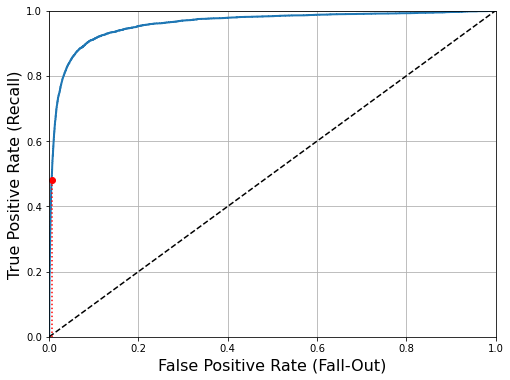

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
                               # Not shown
plt.show()

Una forma de **comparar los clasificadores** es medir el **área bajo la curva** (AUC). Un clasificador **perfecto** tendrá un **AUC ROC igual a 1**, mientras que un **clasificador** puramente **aleatorio** tendrá un **AUC ROC igual a 0,5**. Scikit-Learn proporciona una función para calcular el ROC AUC:

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**¿Cuando debo ocupar la curva ROC o la curva de PR (precisión/recall(sensibilidad))?**

Como regla general, debería preferir la curva PR siempre que la clase positiva tenga pocas instancias en el set de datos o cuando le preocupen más los falsos positivos que los falsos negativos. En caso contrario, utilice la curva ROC. Por ejemplo, al observar la curva ROC anterior (y la puntuación AUC del ROC), puede pensar que el clasificador es realmente bueno. Pero esto **se debe principalmente a que hay pocos positivos (5s) en comparación con los negativos (no 5s)**. En cambio, la curva PR deja claro que el clasificador tiene margen de mejora (la curva podría estar más cerca de la esquina superior izquierda).

Ahora vamos a entrenar un RandomForestClassifier para comparar su curva ROC y su puntuación AUC ROC con las del SGDClassifier. Para esto, hay que obtener las puntuaciones de cada instancia del conjunto de entrenamiento. Pero debido a su funcionamiento (véase el capítulo 7), la clase RandomForestClassifier no tiene un método decision_function(). En su lugar, tiene un método predict_proba()(los clasificadores de Scikit-Learn suelen tener uno o el otro, o ambos). El método predict_proba() devuelve una matriz que contiene una fila por instancia y una columna por clase, cada una de las cuales contiene la probabilidad de que la instancia dada pertenezca a la clase dada (por ejemplo, 70% de probabilidad de que la imagen represente un 5):

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

La función roc_curve() espera **etiquetas y puntuaciones**, pero tambien puede darle probabilidades de clase. Utilicemos la probabilidad de la clase positiva como puntuación:


In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Ahora está listo para trazar la curva ROC. Es útil graficar también la primera curva ROC para compararlas.

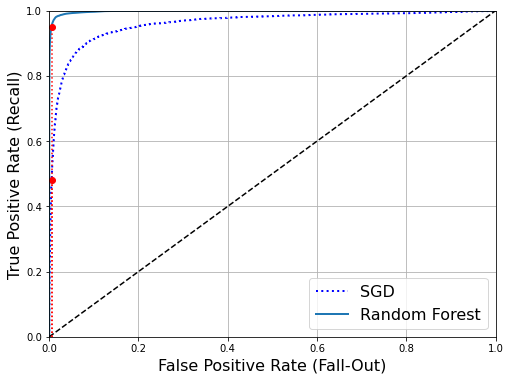

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

La curva ROC del RandomForestClassifier es mucho mejor que la del SGDClassifier: se acerca mucho más a la esquina superior izquierda. Como resultado, su puntuación AUC ROC es también significativamente mejor:

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Intente medir las puntuaciones de precisión y recall: debería encontrar un 99,0% de precisión y un 86,6% de recall. No está nada mal. Ahora ya sabe cómo entrenar clasificadores binarios, elegir la métrica adecuada para su tarea, evaluar sus clasificadores utilizando la validación cruzada, seleccionar la compensación precisión/recuperación que se ajuste a sus necesidades y utilizar las curvas ROC y las puntuaciones ROC AUC para comparar varios modelos. Ahora vamos a intentar detectar algo más que los 5s.

### Multiclass Classification

Algunos algoritmos (como los *clasificadores SGD*, los clasificadores *Random Forest* y los clasificadores *Naive Bayes*) **son capaces de manejar múltiples clases de forma nativa**. Otros (como los clasificadores de regresión logística o los de máquinas de vectores de apoyo) son clasificadores estrictamente binarios. Sin embargo, hay varias estrategias que se pueden utilizar para realizar una clasificación multiclase con múltiples clasificadores binarios.

Una forma de crear un sistema que pueda clasificar las imágenes de dígitos en 10 clases (de 0 a 9) es entrenar 10 clasificadores binarios, uno para cada dígito (un detector 0, un detector 1, un detector 2, etc.). Luego, cuando se quiere clasificar una imagen, se obtiene la puntuación de la decisión de cada clasificador para esa imagen y se selecciona la clase cuyo clasificador da la puntuación más alta. Esto se llama la estrategia de **one-versus-the-rest** (OvR) (también llamada uno contra todos).

Otra estrategia consiste en entrenar un clasificador binario para cada par de dígitos: uno para distinguir 0s y 1s, otro para 0s y 2s, otro para 1s y 2s, y así sucesivamente. Esto se denomina estrategia de **one-versus-one** (OvO). Si hay N clases, es necesario entrenar $N \times \frac{N - 1}{2}$ clasificadores. Para el problema MNIST, esto significa entrenar 45 clasificadores binarios. Cuando se quiere clasificar una imagen, hay que pasarla por los 45 clasificadores y ver qué clase gana más duelos. La principal ventaja de OvO es que cada clasificador sólo necesita ser entrenado en la parte del conjunto de entrenamiento correspondiente a las dos clases que debe distinguir.

Algunos algoritmos, como **Support Vector Machine classifiers, se adaptan mal al tamaño del conjunto de entrenamiento**. Para estos algoritmos se prefiere OvO porque **es más rápido entrenar muchos clasificadores en conjuntos de entrenamiento pequeños que entrenar pocos clasificadores en conjuntos de entrenamiento grandes**. Sin embargo, **para la mayoría de los algoritmos de clasificación binaria, se prefiere OvR**.

Scikit-Learn detecta cuando se intenta utilizar un algoritmo de clasificación binaria para una tarea de clasificación multiclase, y ejecuta automáticamente OvR u OvO, dependiendo del algoritmo. Probemos esto con un Support Vector Machine classifiers (véase el capítulo 5), utilizando la clase sklearn.svm.SVC:

In [38]:
from sklearn.svm import SVC 
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5 set completo 
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Scikit-Learn utilizó en este caso la estrategia OvO: entrenó 45 clasificadores binarios, obtuvo sus puntuaciones de decisión para la imagen, y seleccionó la clase que ganó más duelos.

Si llamas al método decision_function(), verás que devuelve 10 puntuaciones por instancia (en lugar de sólo 1). Es decir, una puntuación por clase:

In [39]:
some_digit_scores = svm_clf.decision_function([some_digit])
print("puntaje de cada categoria:\n ",some_digit_scores)
print("posibilidades de clasificacion: ",svm_clf.classes_)
print("resultado de clasificacion: ",svm_clf.classes_[5])

puntaje de cada categoria:
  [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
posibilidades de clasificacion:  [0 1 2 3 4 5 6 7 8 9]
resultado de clasificacion:  5


**NOTA**|
:----------------------------:|
Cuando un clasificador es entrenado, almacena la lista de clases objetivo en su atributo classes_, ordenado por valor. En este caso, el índice de cada clase en la matriz classes_ coincide convenientemente con la propia clase (por ejemplo, la clase en el índice 5 resulta ser la clase 5), pero en general no tendrás tanta suerte.

Si quieres forzar a Scikit-Learn a usar la estrategia de *one-versus-one* o *one-versus-the-rest*, puedes usar las clases OneVsOneClassifier o OneVsRestClassifier. Simplemente cree una instancia y pase un clasificador a su constructor (ni siquiera tiene que ser un clasificador binario). Por ejemplo, este código crea un clasificador multiclase utilizando la estrategia OvR, basado en un SVC: 

In [40]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


array([5], dtype=uint8)

Entrenar un SGDClassifier (o un randomForestClassifier) es igual de fácil:

In [42]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Esta vez Scikit-Learn no tuvo que ejecutar OvR u OvO porque los clasificadores SGD pueden clasificar directamente las instancias en múltiples clases. El método decision_function() devuelve ahora un valor por clase. Veamos la puntuación que el clasificador SGD asignó a cada clase

In [46]:
sgd_clf.decision_function([some_digit])

3

Se puede ver que el clasificador está bastante seguro de su predicción: casi todas las puntuaciones son mayoritariamente negativas, mientras que la clase 5 tiene una puntuación de 2412,5. El modelo tiene una ligera duda respecto a la clase 3, que obtiene una puntuación de 573,5. Ahora, por supuesto, se quiere evaluar este clasificador. Como es habitual, puede utilizar la validación cruzada. Utiliza la función cross_val_core() para evaluar la precisión del SGDClassifier:

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Obtiene más del 84% en todos los pliegues de prueba. Si utilizara un clasificador aleatorio, obtendría un 10% de precisión, por lo que no es una puntuación tan mala, pero aún puede hacerlo mucho mejor. El simple hecho de escalar las entradas (como se discute en el capítulo 2) aumenta la precisión por encima del 89%:


In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Análisis de errores

Si se tratara de un proyecto real, ahora seguiría los pasos de su lista de comprobación de proyectos de aprendizaje automático (véase el archivo guia de pasos). Exploraría las opciones de preparación de datos, probaría varios modelos (preseleccionando los mejores y ajustando sus hiperparámetros mediante GridSearchCV) y automatizaría todo lo posible. En este caso, supondremos que ha encontrado un modelo prometedor y quiere encontrar formas de mejorarlo. Una forma de hacerlo es analizar los tipos de errores que comete. En primer lugar, observe la matriz de confusión. Necesitas hacer predicciones usando la función cross_val_predict(), y luego llamar a la función confusion_matrix(), tal como hiciste antes:

Primero, mira la matriz de confusión. Tienes que hacer predicciones usando la función cross_val_predict(), y luego llamar a la función confusion_matrix(), tal y como hiciste antes:

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

Son muchos números. A menudo es más conveniente mirar una representación de imagen de la matriz de confusión, utilizando la función matshow() de Matplotlib:

<AxesSubplot:>

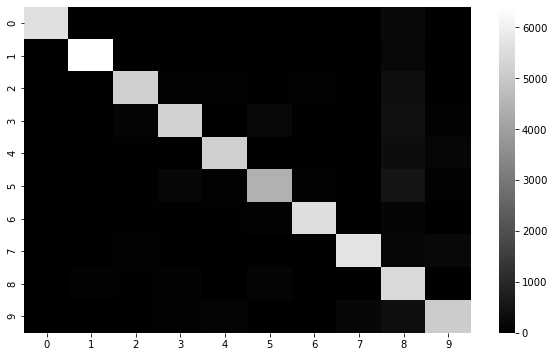

In [65]:
fig, ax = plt.subplots(1, figsize=(10,6))
sns.heatmap(conf_mx, cmap=plt.cm.gray)

Esta matriz de confusión se ve bastante bien, ya que la mayoría de las imágenes están en la diagonal principal, lo que significa que fueron clasificadas correctamente. **Los 5s parecen ligeramente más oscuros que los otros dígitos, lo que podría significar que hay menos imágenes de 5s en el conjunto de datos o que el clasificador no funciona tan bien con los 5s como con otros dígitos.** De hecho, se puede comprobar que ambos son el caso. 

Vamos a centrarnos en el gráfico de errores. En primer lugar, *hay que dividir cada valor de la matriz de confusión por el número de imágenes de la clase correspondiente para poder comparar las tasas de error en lugar de los números absolutos de errores (que harían que las clases abundantes parecieran injustamente malas)*:

In [72]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [74]:
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

Rellena la diagonal con ceros para mantener sólo los errores, y traza el resultado:

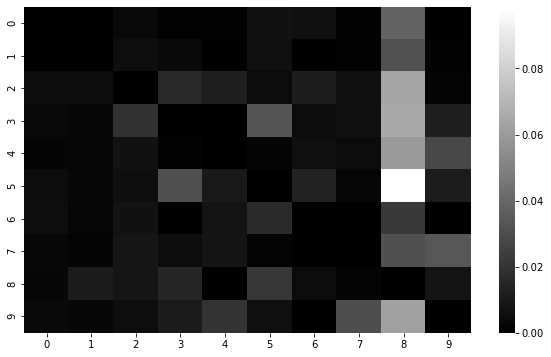

In [76]:
np.fill_diagonal(norm_conf_mx, 0)
fig, ax = plt.subplots(1, figsize=(10,6))
sns.heatmap(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Puede ver claramente los tipos de errores que comete el clasificador. Recuerde que las filas representan las clases reales, mientras que las columnas representan las clases predichas. **La columna de la clase 8 es bastante brillante, lo que indica que muchas imágenes se clasifican erróneamente como 8s**. Sin embargo, *la fila de la clase 8 no es tan mala, lo que indica que los 8 reales se clasifican correctamente como 8*. Como puede ver, **la matriz de confusión no es necesariamente simétrica. También puede ver que los 3 y los 5 se confunden a menudo (en ambas direcciones).**

El análisis de la matriz de confusión a menudo permite descubrir formas de mejorar el clasificador. Observando este gráfico, parece que sus esfuerzos deberían dedicarse a reducir los 8 falsos. Por ejemplo, **podría intentar reunir más datos de entrenamiento de dígitos que parecen 8 (pero no lo son) para que el clasificador pueda aprender a distinguirlos de los 8 reales. También podría diseñar nuevas características que ayuden al clasificador, por ejemplo, escribiendo un algoritmo para contar el número de bucles cerrados (por ejemplo, el 8 tiene dos, el 6 tiene uno, el 5 no tiene ninguno). O podría preprocesar las imágenes (por ejemplo, utilizando ScikitImage, Pillow u OpenCV) para que algunos patrones, como los bucles cerrados, destaquen más.**

Analizar los errores individuales también puede ser una buena manera de obtener información sobre lo que está haciendo su clasificador y por qué está fallando, pero es más difícil y requiere más tiempo. Por ejemplo, vamos a trazar ejemplos de 3s y 5s (la función plot_digits() sólo utiliza la función imshow() de Matplotlib; ver el cuaderno Jupyter de este capítulo para más detalles):

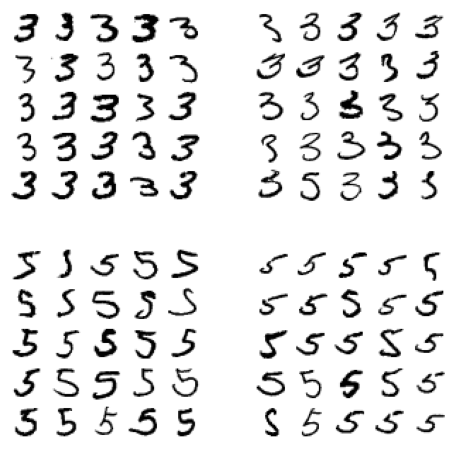

In [77]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

Los dos bloques de 5 × 5 de la izquierda muestran dígitos clasificados como 3s, y los dos bloques de 5 × 5 de la derecha muestran imágenes clasificadas como 5s. Algunos de los dígitos que el clasificador equivoca (es decir, en los bloques de abajo a la izquierda y de arriba a la derecha) *están tan mal escritos que incluso un humano tendría problemas para clasificarlos (por ejemplo, el 5 de la primera fila y la segunda columna parece realmente un 3 mal escrito)*. Sin embargo, la mayoría de las imágenes mal clasificadas nos parecen errores obvios, y es difícil entender por qué el clasificador cometió los errores que cometió. **La razón es que utilizamos un simple SGDClassifier, que es un modelo lineal.** Todo lo que hace es asignar un peso por clase a cada píxel, y cuando ve una nueva imagen simplemente suma las intensidades ponderadas de los píxeles 3 para obtener una puntuación para cada clase. Así que como los 3s y los 5s sólo se diferencian por unos pocos píxeles, este modelo los confundirá fácilmente.

**La principal diferencia entre 3s y 5s es la posición de la pequeña línea que une la línea superior con el arco inferior.** Si se dibuja un 3 con la unión ligeramente desplazada hacia la izquierda, el clasificador podría clasificarlo como un 5, y viceversa. En otras palabras, este clasificador es bastante sensible al desplazamiento y la rotación de la imagen.** Así que una forma de reducir la confusión 3/5 sería preprocesar las imágenes para asegurarse de que están bien centradas y no demasiado rotadas. Esto probablemente también ayudará a reducir otros errores.**

### Clasificación multietiqueta

Hasta ahora, cada instancia se ha asignado siempre a una sola clase. En algunos casos, es posible que desee que su clasificador emita varias clases para cada instancia. Piense en un clasificador de reconocimiento de caras: ¿qué debería hacer si reconoce a varias personas en la misma imagen? Debería asignar una etiqueta por cada persona que reconozca. Supongamos que el clasificador ha sido entrenado para reconocer tres caras, Alice, Bob y Charlie. Entonces, cuando al clasificador se le muestra una imagen de Alicia y Charlie, debería dar como resultado [1, 0, 1] (lo que significa "Alicia sí, Bob no, Charlie sí"). Un sistema de clasificación de este tipo que produce múltiples etiquetas binarias se denomina sistema de clasificación multietiqueta.

No vamos a entrar todavía en el reconocimiento de caras, pero vamos a ver un ejemplo más sencillo, sólo para ilustrar:


In [78]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Este código crea una matriz y_multilabel que contiene dos etiquetas objetivo para cada imagen de dígitos: la primera indica si el dígito es o no grande (7, 8 o 9), y la segunda indica si es o no impar. Las siguientes líneas crean una instancia de KNeighborsClassifier (que soporta la clasificación multietiqueta, aunque no todos los clasificadores lo hacen), y lo entrenamos utilizando la matriz de objetivos múltiples. Ahora puede hacer una predicción, y observe que produce dos etiquetas:


In [79]:
knn_clf.predict([some_digit])


array([[False,  True]])

¡Y lo hace bien! Efectivamente, el dígito 5 no es grande (Falso) ni impar (Verdadero).

Hay muchas formas de evaluar un clasificador multietiqueta, y la selección de la métrica adecuada depende realmente de su proyecto. Un enfoque es medir el $F_1$ score para cada etiqueta individual (o cualquier otra métrica del clasificador binario discutida anteriormente), y luego simplemente calcular la puntuación media. Este código calcula la puntuación F media de todas las etiquetas:


In [80]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel,cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Sin embargo, *esto supone que todas las etiquetas tienen la misma importancia, lo que puede no ser el caso*. En particular, **si tiene muchas más fotos de Alicia que de Bob o Charlie, puede querer dar más peso a la puntuación del clasificador en las fotos de Alicia. Una opción sencilla es dar a cada etiqueta un peso igual a su soporte (es decir, el número de instancias con esa etiqueta objetivo)**. Para ello, basta con establecer average="weighted" en el código anterior

### Clasificación multisalida

El último tipo de tarea de clasificación que vamos a tratar aquí se denomina clasificación multisalida-multiclase (o simplemente clasificación multisalida). Es simplemente una generalización de la clasificación multietiqueta en la que cada etiqueta puede ser multiclase (es decir, puede tener más de dos valores posibles).

Para ilustrar esto, construyamos un sistema que elimine el ruido de las imágenes. Tomará como entrada una imagen de dígitos con ruido, y (con suerte) dará como resultado una imagen de dígitos limpia, representada como una matriz de intensidades de píxeles, al igual que las imágenes MNIST. Obsérvese que la salida del clasificador es multietiqueta (una etiqueta por píxel) y que cada etiqueta puede tener múltiples valores (la intensidad del píxel va de 0 a 255). Se trata, pues, de un ejemplo de sistema de clasificación con múltiples salidas.

NOTA

La línea entre la clasificación y la regresión es a veces borrosa, como en este ejemplo. Podría decirse que la predicción de la intensidad de los píxeles es más parecida a la regresión que a la clasificación. Además, los sistemas de salida múltiple no se limitan a las tareas de clasificación; incluso se puede tener un sistema que produzca múltiples etiquetas por instancia, incluyendo tanto etiquetas de clase como etiquetas de valor.

Empecemos por crear los conjuntos de entrenamiento y prueba tomando las imágenes MNIST y añadiendo ruido a sus intensidades de píxeles con la función randint() de NumPy. Las imágenes de destino serán las imágenes originales:

In [81]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Echemos un vistazo a una imagen del conjunto de pruebas **(sí, estamos husmeando en los datos de prueba, así que deberías fruncir el ceño ahora mismo):**

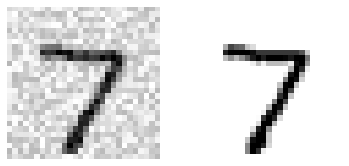

In [82]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

A la izquierda está la imagen de entrada con ruido, y a la derecha la imagen de destino limpia. Ahora vamos a entrenar el clasificador y hacer que limpie esta imagen:

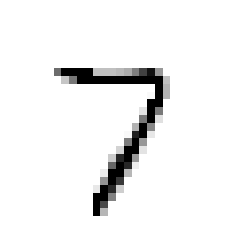

In [83]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Parece estar bastante cerca del objetivo. Con esto concluye nuestro recorrido por la clasificación. Ahora debería saber cómo seleccionar buenas métricas para las tareas de clasificación, elegir el equilibrio adecuado entre precisión y recuperación, comparar clasificadores y, en general, construir buenos sistemas de clasificación para una variedad de tareas.

# Exercises

Try to build a classifier for the MNIST dataset that achieves over
97% accuracy on the test set. Hint: the KNeighborsClassifier
works quite well for this task; you just need to find good
hyperparameter values (try a grid search on the weights and
n_neighbors hyperparameters).


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
#grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
#grid_search.fit(X_train, y_train)

#best=>{'n_neighbors': 4, 'weights': 'distance'}

Data Augmentation

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])